# About Dataset

## Source
https://www.kaggle.com/datasets/camnugent/california-housing-prices

## Context
This is the dataset used in the second chapter of Aurélien Géron's recent book 'Hands-On Machine learning with Scikit-Learn and TensorFlow'. It serves as an excellent introduction to implementing machine learning algorithms because it requires rudimentary data cleaning, has an easily understandable list of variables and sits at an optimal size between being to toyish and too cumbersome.

The data contains information from the 1990 California census. So although it may not help you with predicting current housing prices like the Zillow Zestimate dataset, it does provide an accessible introductory dataset for teaching people about the basics of machine learning.

## Content
The data pertains to the houses found in a given California district and some summary stats about them based on the 1990 census data. Be warned the data aren't cleaned so there are some preprocessing steps required! The columns are as follows, their names are pretty self explanitory:

1. longitude: A measure of how far west a house is; a higher value is farther west

2. latitude: A measure of how far north a house is; a higher value is farther north

3. housingMedianAge: Median age of a house within a block; a lower number is a newer building

4. totalRooms: Total number of rooms within a block

5. totalBedrooms: Total number of bedrooms within a block

6. population: Total number of people residing within a block

7. households: Total number of households, a group of people residing within a home unit, for a block

8. medianIncome: Median income for households within a block of houses (measured in tens of thousands of US Dollars)

9. medianHouseValue: Median house value for households within a block (measured in US Dollars)

10. oceanProximity: Location of the house w.r.t ocean/sea

## Objective

Answer two business questions

- as younger the housingMedianAge, higher the medianHousevalue?

- as higher the medianIncome, higher the medianHousevalue?

Get a better prediction than the book 'Hands-On Machine learning with Scikit-Learn and TensorFlow', the tuned model with the train set get a RMSE: 49.682 and the final evaluation was 47.730,2 for the test set. The strategy is try different methods os scaling, hyperparameters, algorithms and try eliminate some features

# 1. IMPORTS

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PowerTransformer, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.linear_model import ElasticNet, SGDRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from yellowbrick.model_selection import RFECV, LearningCurve
import scipy
import plotly.express as px

## 1.1 Functions

In [59]:
def barplot(coluna):  
    plt.figure(figsize=(15, 5))
    ax = sns.barplot(x=coluna.value_counts().index, y=coluna.value_counts())
    ax.set_xlim(limits(coluna))
    ax.grid(False)
    
def limits(coluna):
    q1 = coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    amplitude = q3 - q1
    return q1 - 1.5 * amplitude, q3 + 1.5 * amplitude

def boxplot(coluna):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)
    sns.boxplot(x=coluna, ax=ax1)
    ax2.set_xlim(limits(coluna))
    sns.boxplot(x=coluna, ax=ax2)
    
def exclude_outliers(df, nome_coluna):
    qtde_linhas = df.shape[0]
    lim_inf, lim_sup = limits(df[nome_coluna])
    df = df.loc[(df[nome_coluna] >= lim_inf) & (df[nome_coluna] <= lim_sup), :]
    linhas_removidas = qtde_linhas - df.shape[0]
    return df,  linhas_removidas
    
def display_scores(model_name, scores):
    RMSE = scores
    mean = scores.mean()
    std = scores.std()
    dicionario = {'Model': model_name, 'Mean RMSE': mean, 'Standard deviation':std}
    return dicionario

## 1.2 Download data

In [60]:
#collecting data
df_original = pd.read_csv('housing.csv')
df_original.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# 2.0 Data descriptions

In [61]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


The feature 'total_bedrooms' has some NA values, we are going to have to treat this later. Beyond that, we can see that 'ocean_proximity' it's a object type, so it will be necessary to transform this feature with a encode method.

In [62]:
df_original.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


median_income is in another scale than we expect. The real values are multiplied by 10000

array([[<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'housing_median_age'}>],
       [<AxesSubplot:title={'center':'total_rooms'}>,
        <AxesSubplot:title={'center':'total_bedrooms'}>,
        <AxesSubplot:title={'center':'population'}>],
       [<AxesSubplot:title={'center':'households'}>,
        <AxesSubplot:title={'center':'median_income'}>,
        <AxesSubplot:title={'center':'median_house_value'}>]],
      dtype=object)

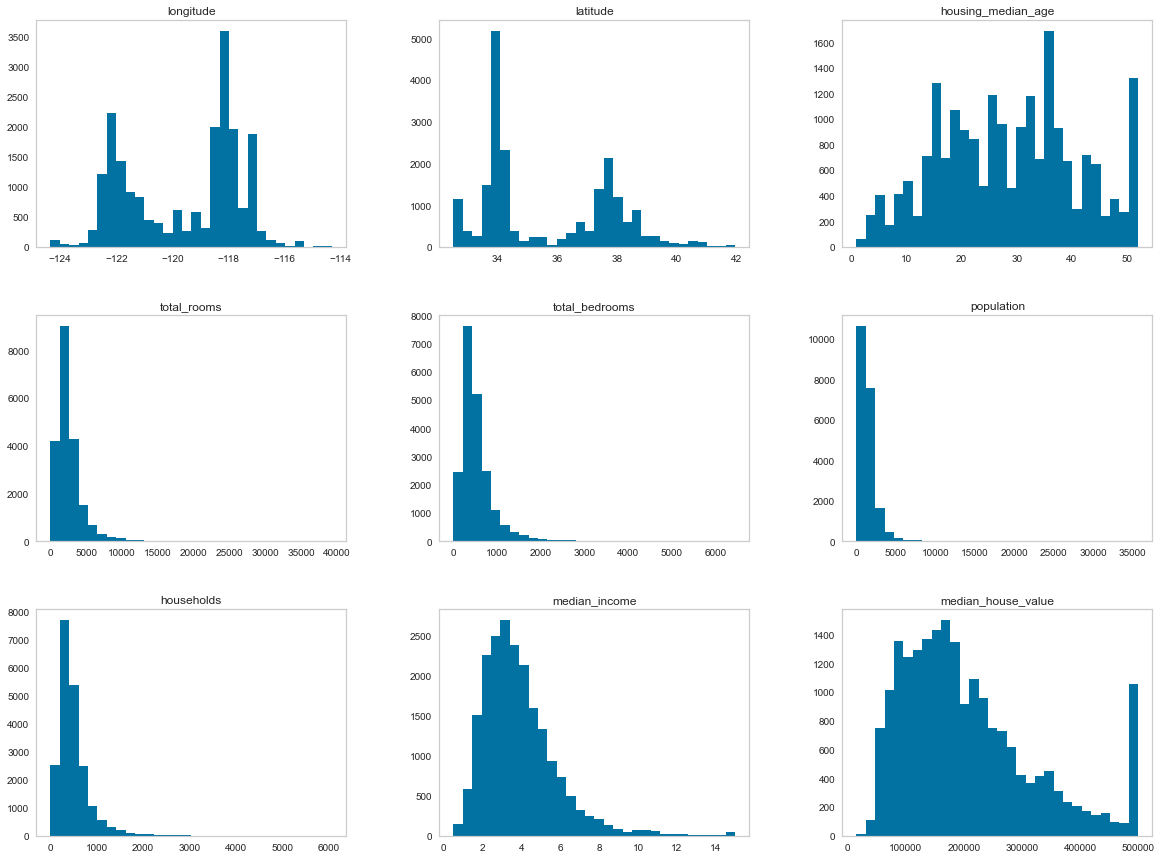

In [63]:
df_original.hist(bins = 30, figsize=(20,15), grid = False)

# 3.0 Split train and test set

Before we split the data, we can see that is a high concentration of the maximum value on the target. The book told us that the value was capped to 500.001 when actually was beyond that. So we are going to exclude this values for the algorithm can learn that the price can go beyond that limit.

In [64]:
df1 = df_original.copy()

In [65]:
df1.drop(df1[df1['median_house_value'] == 500001].index, inplace = True)

In [66]:
df1.reset_index(drop=True, inplace=True)

In [67]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19675 entries, 0 to 19674
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           19675 non-null  float64
 1   latitude            19675 non-null  float64
 2   housing_median_age  19675 non-null  float64
 3   total_rooms         19675 non-null  float64
 4   total_bedrooms      19475 non-null  float64
 5   population          19675 non-null  float64
 6   households          19675 non-null  float64
 7   median_income       19675 non-null  float64
 8   median_house_value  19675 non-null  float64
 9   ocean_proximity     19675 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.5+ MB


<AxesSubplot:>

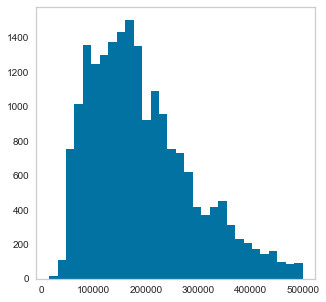

In [68]:
df1['median_house_value'].hist(bins = 30, figsize=(5,5), grid = False)

In [69]:
df1[df1['median_house_value'] == 500001.0]['median_house_value'].count()

0

In [70]:
# change some variables to not have unexpected characteres
df1.loc[df1['ocean_proximity']=='<1H OCEAN', 'ocean_proximity'] = '1H_OCEAN'
df1.loc[df1['ocean_proximity']=='NEAR BAY', 'ocean_proximity'] = 'NEAR_BAY'
df1.loc[df1['ocean_proximity']=='NEAR OCEAN', 'ocean_proximity'] = 'NEAR_OCEAN'

Following the example of the book tha we based on, the "median_income" has been told, by experts of the business,that it is the most important feature, we can check that later, but for now lets assume that. To avoid a sampling bias in the test set over the data set, when we separate in train and test set, we create a new collumn to auxiliate that stratification and maintain the proportion.

In this technique, we create a new column grouping the values distributed in the bins and adding a label to identify each group.

In [71]:
#create new collumn
df1['income_cat'] = pd.cut(df1['median_income'], bins = [0., 1.5, 3.0, 4.5, 6., np.inf], labels = [1, 2, 3, 4, 5])
df1[['median_income','income_cat']].head()

,median_income,income_cat
0,8.3252,5
1,8.3014,5
2,7.2574,5
3,5.6431,4
4,3.8462,3


The method StratifiedShuffleSplit allow us to split the dataset based on some conditional, in this case the feature "median_income". That is a good method if we want guarantee that the test set proportion is similar to the all dataset and avoid a sampling bias.

In [72]:
#separate the train and test set
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(df1,df1['income_cat']):
    strat_train_set = df1.loc[train_index]
    strat_test_set  = df1.loc[test_index]

print(strat_test_set['income_cat'].value_counts()/len(strat_test_set))

print(strat_test_set['income_cat'].value_counts())

3    0.361118
2    0.332910
4    0.177891
5    0.086658
1    0.041423
Name: income_cat, dtype: float64
3    1421
2    1310
4     700
5     341
1     163
Name: income_cat, dtype: int64


In [73]:
#remove the income_cat
for set_ in (strat_train_set,strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

# 4.0 Feature engineering

In [74]:
df_train = strat_train_set.copy()

The book suggest the creation of some features. Analysing the original features: rooms, bedrooms, population. Looking at them in a isolate form they seem to not tell us much, mainly because it´s not only the information of a house but the block. Combining this features to generate new one that explains more the context seems reasonable.

In [75]:
df_train['rooms_per_household'] = df_train['total_rooms']/df_train['households']
df_train['bedrooms_per_room'] = df_train['total_bedrooms']/df_train['total_rooms']
df_train['population_per_household'] = df_train['population']/df_train['households']
df_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
38,-122.26,37.83,52.0,1470.0,330.0,689.0,309.0,3.4800,191400.0,NEAR_BAY,4.757282,0.224490,2.229773
17797,-122.32,40.57,15.0,2524.0,449.0,1374.0,467.0,3.3816,93800.0,INLAND,5.404711,0.177892,2.942184
4783,-118.26,34.01,47.0,1269.0,323.0,1628.0,325.0,1.5089,115800.0,1H_OCEAN,3.904615,0.254531,5.009231
10621,-117.92,33.84,38.0,1316.0,263.0,671.0,278.0,3.2969,220000.0,1H_OCEAN,4.733813,0.199848,2.413669
18654,-120.98,37.57,27.0,925.0,176.0,449.0,168.0,2.6406,129700.0,INLAND,5.505952,0.190270,2.672619


# 5. Exploratory Data analysis

## 5.1 Univariate analysis

### 5.1.1 Numerical features

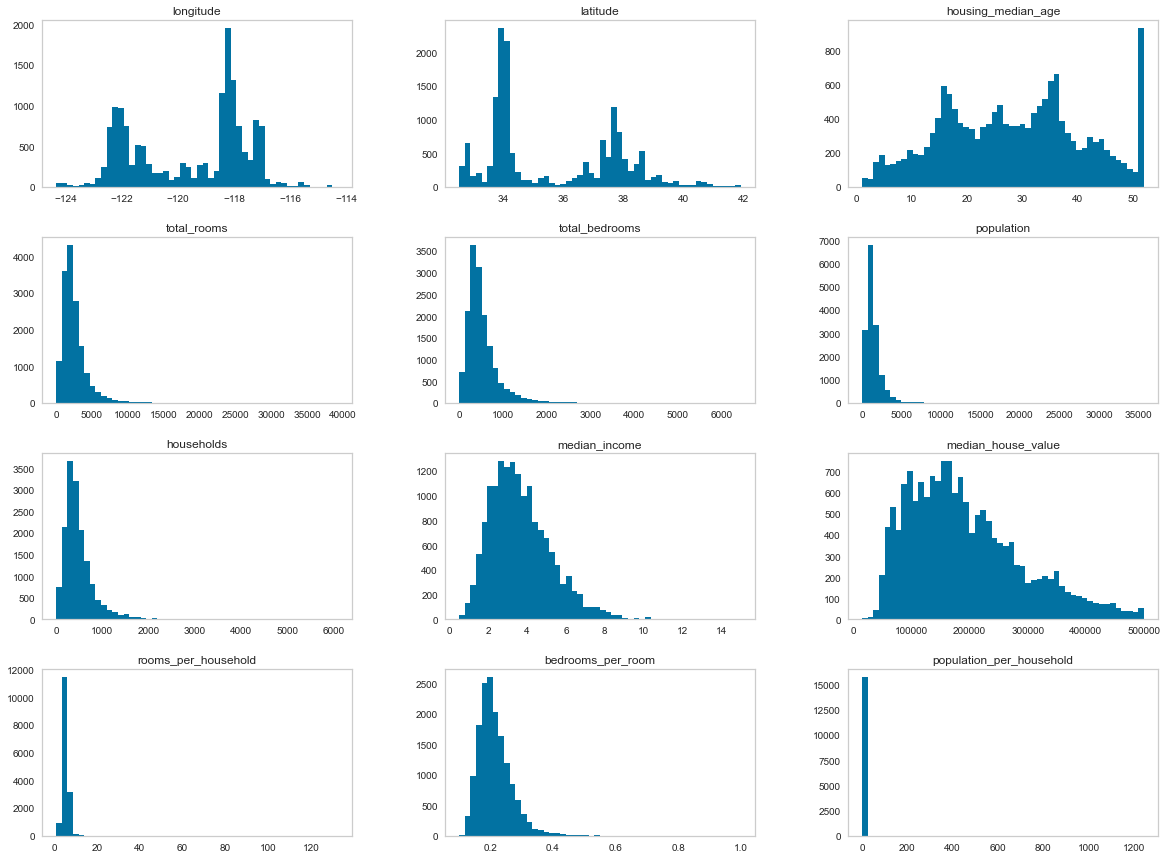

In [76]:
df_train.hist(bins=50, figsize=(20,15), grid=False);

In [77]:
skew_columns = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'rooms_per_household',
       'bedrooms_per_room', 'population_per_household']

for columns in skew_columns:
    skew = scipy.stats.skew(df_train[columns])
    kurtose = scipy.stats.kurtosis(df_train[columns])
    print(f'skewness of {columns} is {skew} and kurtosis is {kurtose}')

skewness of longitude is -0.2868376955060278 and kurtosis is -1.3289765064667889
skewness of latitude is 0.44686745579617915 and kurtosis is -1.1363322852393636
skewness of housing_median_age is 0.06502739878854388 and kurtosis is -0.7963034667947588
skewness of total_rooms is 4.079832475375014 and kurtosis is 31.157921272869885
skewness of total_bedrooms is nan and kurtosis is nan
skewness of population is 5.2558808575871305 and kurtosis is 84.87767466753051
skewness of households is 3.393800283578301 and kurtosis is 21.82823186669488
skewness of median_income is 0.8972447294447529 and kurtosis is 1.2667392580147228
skewness of median_house_value is 0.8097654833574329 and kurtosis is 0.14790177108597735
skewness of rooms_per_household is 17.824914861312347 and kurtosis is 671.4428596836052
skewness of bedrooms_per_room is nan and kurtosis is nan
skewness of population_per_household is 85.91895965523507 and kurtosis is 8206.492934092008


The features dont have a normal distribution, some algorithms learn better if they do. We will try some transformation in the pre processing.

### 5.1.2 Categorical Features

In [78]:
df_train.groupby('ocean_proximity')['ocean_proximity'].count()

ocean_proximity
1H_OCEAN      6861
INLAND        5196
ISLAND           3
NEAR_BAY      1704
NEAR_OCEAN    1976
Name: ocean_proximity, dtype: int64

## 5.2 Bivariate analysis

In [88]:
px.density_mapbox(df_train, lat='latitude', lon='longitude', z='median_house_value', radius=5,
                        zoom=5, mapbox_style='open-street-map')

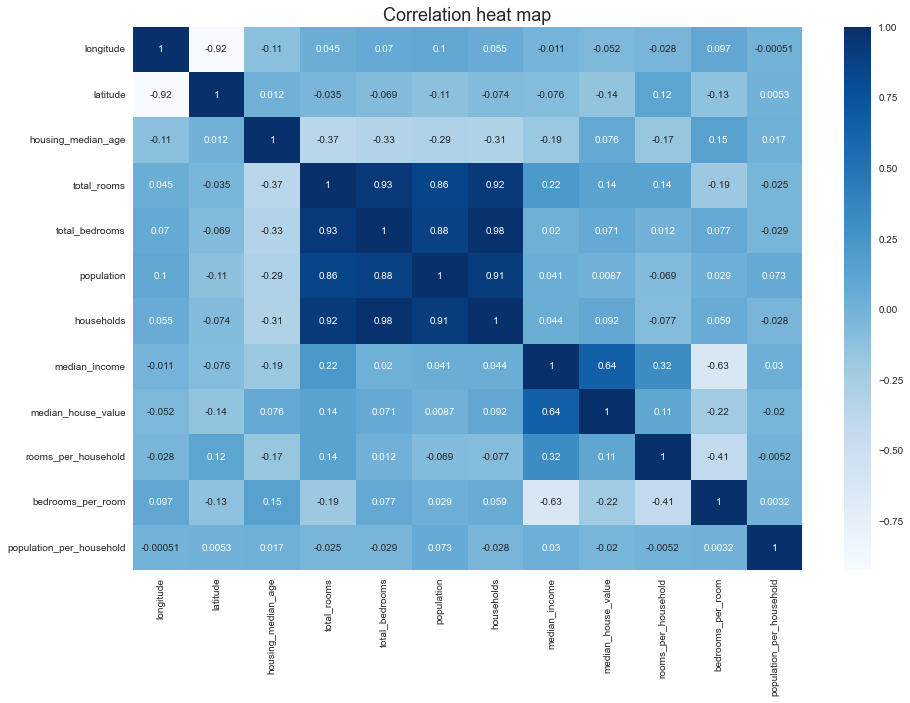

In [80]:
plt.figure(figsize = (15,10))
plt.title('Correlation heat map', fontsize=18)
sns.heatmap(df_train.corr(), annot=True, cmap='Blues' );

As the book said, we can confirm now that median income has a high correlation with the median house value which corroborates for the stratified split in the beginning. Other thing that we can notice it's a high correlation between the features: total rooms, total bedrooms anda households. Maybe this features are carrying the same information and its not necessary have them all.

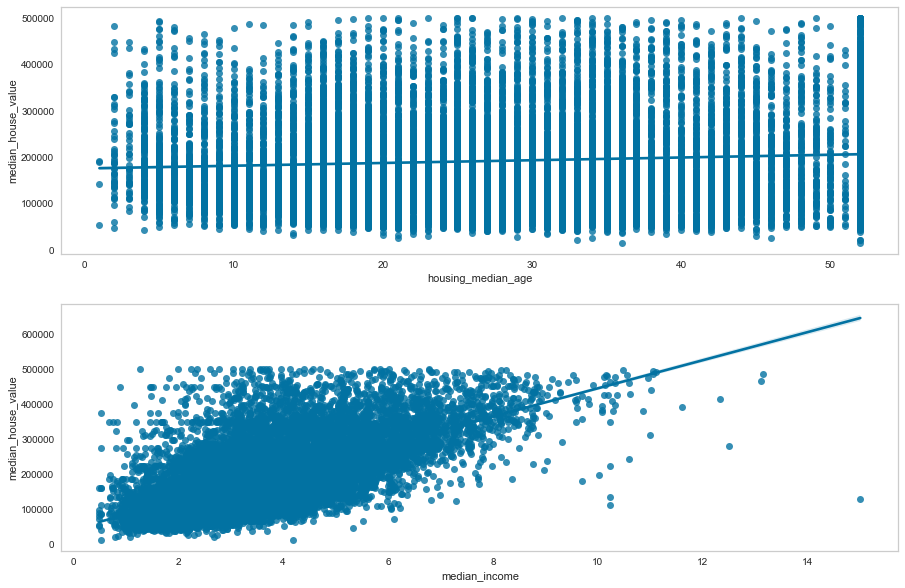

In [81]:
#Answer the two business questions
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
sns.regplot(x="housing_median_age", y="median_house_value", data=df_train)
plt.grid()

plt.subplot(2,1,2)
sns.regplot(x="median_income", y="median_house_value", data=df_train)
plt.grid()

We cant's assume that younger the house, higher the median house value. However, higher the median income, higher the house value we can.

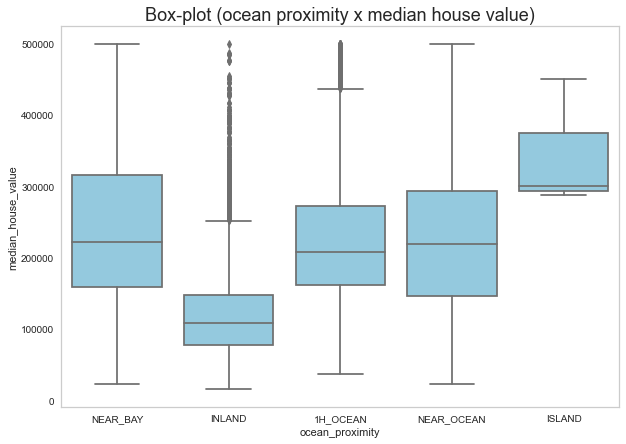

In [82]:
plt.figure(figsize=(10,7))
plt.grid()
plt.title('Box-plot (ocean proximity x median house value)', fontsize=18)
sns.boxplot(x=df_train['ocean_proximity'], y=df_train['median_house_value'], color="skyblue");

The graphic show us that the ocean proximity has some influence on the median house value. When its inland, has the lowest median house value but when it is island, has the highest. This analysis is a litte damaged because only have 3 registers of the island variable.

## 5.3 Multivariate analysis

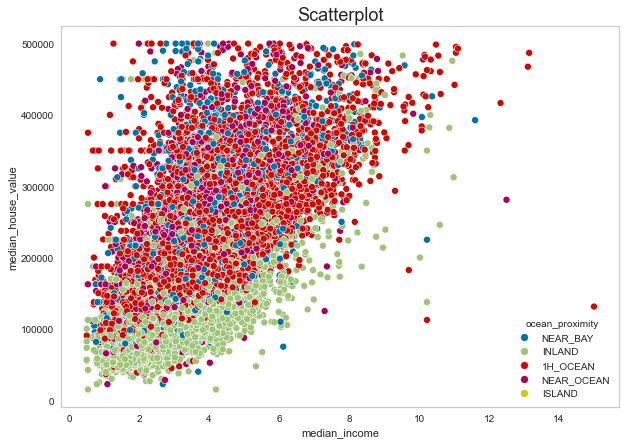

In [83]:
plt.figure(figsize=(10,7))
sns.scatterplot(data=df_train, x='median_income', y='median_house_value', hue='ocean_proximity');
plt.title('Scatterplot', fontsize=18)
plt.grid()

This visualization confirms that when the house is in inland has the lowest price.

# 6. Preprocessing (Pipelines)

In [27]:
#Separate the train set
X_train = df_train.drop('median_house_value', axis = 1)
y_train = df_train['median_house_value'].copy()

For this part, i will build different pipelines with different transformations to evaluate the models.

## 6.1 Pipeline with yeo-johnson and standard scaler

In [28]:
#preprocessing train set with yeo-johnson standard scaler
X_train_num = X_train.drop('ocean_proximity', axis=1)

num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')),
                         ('normal', PowerTransformer(method='yeo-johnson')),
                         ('standard_scaler', StandardScaler())
])

num_features = list(X_train_num)
cat_features = ['ocean_proximity']

full_pipeline = ColumnTransformer([('num', num_pipeline, num_features),
                                  ('cat', OneHotEncoder(), cat_features)
], verbose_feature_names_out=False)

X_train_prepared = pd.DataFrame(full_pipeline.fit_transform(X_train), columns=full_pipeline.get_feature_names_out())
X_train_prepared

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,bedrooms_per_room,population_per_household,ocean_proximity_1H_OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR_BAY,ocean_proximity_NEAR_OCEAN
0,-1.318451,1.055896,1.782406,-0.523576,-0.437691,-0.753722,-0.437965,0.025772,-0.258692,0.396081,-0.975415,0.0,0.0,0.0,1.0,0.0
1,-1.338145,1.812213,-1.066788,0.218680,-0.005212,0.193320,0.148842,-0.041468,0.233388,-0.677733,0.179627,0.0,1.0,0.0,0.0,0.0
2,0.631246,-0.733317,1.429462,-0.710869,-0.466750,0.449894,-0.369255,-1.709146,-1.056291,0.914324,2.027010,1.0,0.0,0.0,0.0,0.0
3,0.818338,-0.842841,0.775113,-0.665098,-0.738572,-0.787143,-0.579233,-0.100515,-0.278143,-0.124432,-0.633104,1.0,0.0,0.0,0.0,0.0
4,-0.747327,0.966189,-0.067162,-1.093963,-1.236269,-1.270169,-1.205841,-0.599935,0.303364,-0.354404,-0.206905,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15735,-1.328298,1.205939,-0.226750,-0.331660,-0.077738,-0.232523,-0.081504,-0.286383,-0.696391,0.859612,-0.386760,0.0,0.0,0.0,1.0,0.0
15736,0.700175,-0.733317,0.922874,0.152961,0.502189,0.868902,0.533680,-1.105125,-0.936104,1.008546,0.870700,1.0,0.0,0.0,0.0,0.0
15737,0.493389,-0.596298,-0.146667,0.515672,0.358153,0.413569,0.496450,0.659045,0.129871,-0.464594,-0.145115,1.0,0.0,0.0,0.0,0.0
15738,0.818338,-0.842841,-0.226750,-0.977135,-0.793590,-0.296075,-0.676897,-0.223859,-1.000805,0.791939,1.111931,1.0,0.0,0.0,0.0,0.0


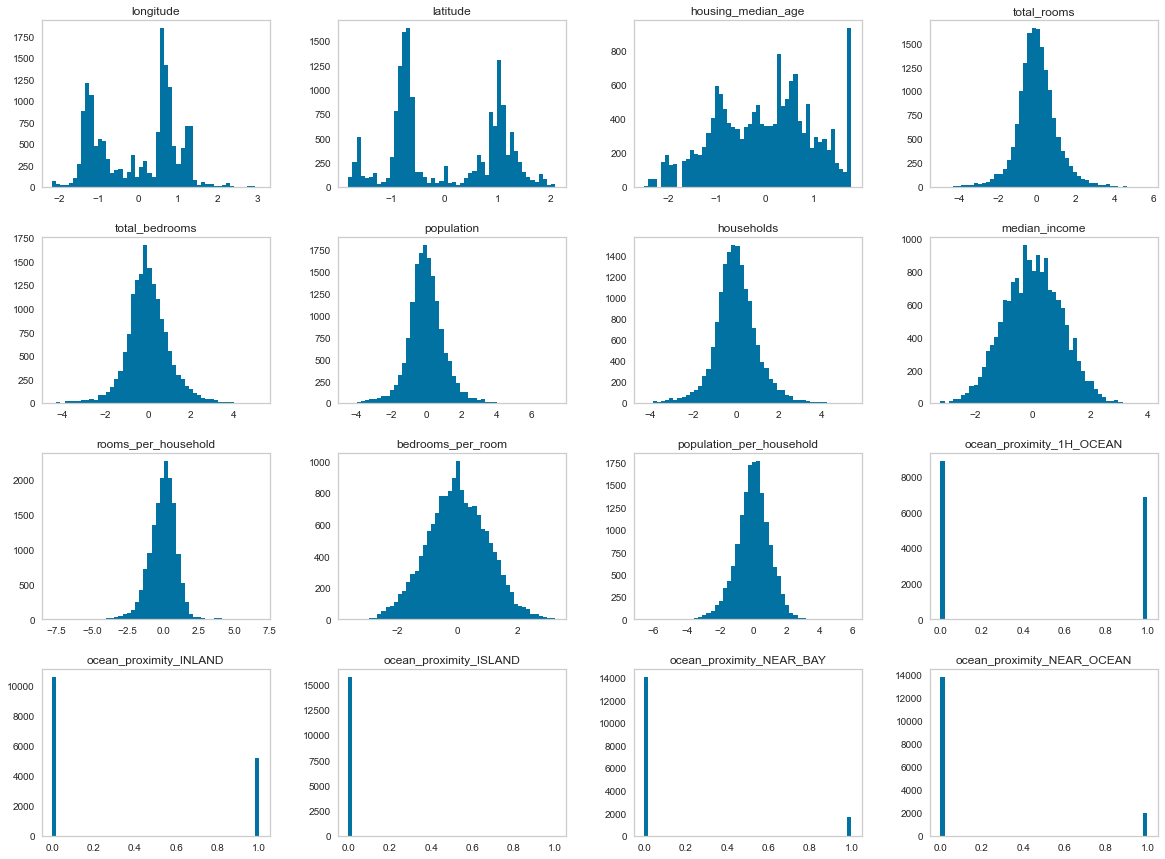

In [29]:
X_train_prepared.hist(bins=50, figsize=(20,15), grid=False);

In [30]:
skew_columns = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
                'total_bedrooms', 'population', 'households', 'median_income', 
                'rooms_per_household','bedrooms_per_room', 'population_per_household']

for columns in skew_columns:
    skew = scipy.stats.skew(X_train_prepared[columns])
    kurtose = scipy.stats.kurtosis(X_train_prepared[columns])
    print(f'skewness of {columns} is {skew} and kurtosis is {kurtose}')

skewness of longitude is -0.1776847746289131 and kurtosis is -1.305971082114551
skewness of latitude is 0.14588497146140525 and kurtosis is -1.4309638869791375
skewness of housing_median_age is -0.11248301908411935 and kurtosis is -0.7255106742916801
skewness of total_rooms is 0.11793240833450232 and kurtosis is 2.1940847233025673
skewness of total_bedrooms is 0.10376360511324295 and kurtosis is 1.9821672389713925
skewness of population is 0.10657472409652917 and kurtosis is 1.9815308890036514
skewness of households is 0.10483834028915702 and kurtosis is 1.8752849562474028
skewness of median_income is -0.0009137491397650329 and kurtosis is -0.1970476440795883
skewness of rooms_per_household is -0.1886287096159711 and kurtosis is 4.125510121890987
skewness of bedrooms_per_room is 0.02144889238965661 and kurtosis is -0.14069073593314574
skewness of population_per_household is -0.10659058037246032 and kurtosis is 1.322625888131883


As we wanted, the features now are close to a normal distribution.

## 6.2 Pipeline with min max scaler

In [56]:
#preprocessing train set with min max scaler
X_train_num_2 = X_train.drop('ocean_proximity', axis=1)

num_pipeline_2 = Pipeline([('imputer', SimpleImputer(strategy='median')),
                         ('min_max_scaler', MinMaxScaler())
])

num_features_2 = list(X_train_num_2)
cat_features_2 = ['ocean_proximity']

full_pipeline_2 = ColumnTransformer([('num', num_pipeline_2, num_features_2),
                                  ('cat', OneHotEncoder(), cat_features_2)
], verbose_feature_names_out=False)

X_train_prepared_2 = pd.DataFrame(full_pipeline_2.fit_transform(X_train), columns=full_pipeline_2.get_feature_names_out())
X_train_prepared_2

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,bedrooms_per_room,population_per_household,median_house_value,ocean_proximity_1H_OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR_BAY,ocean_proximity_NEAR_OCEAN
0,0.208167,0.563966,1.000000,0.037337,0.050908,0.019172,0.050493,0.205521,0.029700,0.138322,0.001237,0.363713,0.0,0.0,0.0,1.0,0.0
1,0.202191,0.856077,0.274510,0.064144,0.069378,0.038372,0.076480,0.198735,0.034617,0.086547,0.001811,0.162476,0.0,1.0,0.0,0.0,0.0
2,0.606574,0.156716,0.901961,0.032224,0.049822,0.045491,0.053125,0.069585,0.023225,0.171701,0.003474,0.207837,1.0,0.0,0.0,0.0,0.0
3,0.640438,0.138593,0.725490,0.033420,0.040509,0.018667,0.045395,0.192894,0.029522,0.110942,0.001385,0.422682,1.0,0.0,0.0,0.0,0.0
4,0.335657,0.536247,0.509804,0.023475,0.027006,0.012445,0.027303,0.147632,0.035385,0.100300,0.001594,0.236496,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15735,0.204183,0.613006,0.470588,0.043212,0.065963,0.028478,0.065296,0.175204,0.025948,0.167810,0.001502,0.262063,0.0,0.0,0.0,1.0,0.0
15736,0.619522,0.156716,0.764706,0.061295,0.097315,0.059254,0.098355,0.108626,0.024101,0.178644,0.002285,0.280620,1.0,0.0,0.0,0.0,0.0
15737,0.582669,0.180171,0.490196,0.078336,0.088623,0.044426,0.096053,0.277017,0.033513,0.095465,0.001626,0.626805,1.0,0.0,0.0,0.0,0.0
15738,0.641434,0.138593,0.470588,0.025917,0.038802,0.027188,0.042105,0.181039,0.023626,0.163130,0.002484,0.315672,1.0,0.0,0.0,0.0,0.0


## 6.3 Pipeline with robust scaler

In [57]:
#preprocessing train set with min max scaler
X_train_num_3 = X_train.drop('ocean_proximity', axis=1)

num_pipeline_3 = Pipeline([('imputer', SimpleImputer(strategy='median')),
                         ('robust_scaler', RobustScaler())
])

num_features_3 = list(X_train_num_3)
cat_features_3 = ['ocean_proximity']

full_pipeline_3 = ColumnTransformer([('num', num_pipeline_3, num_features_3),
                                  ('cat', OneHotEncoder(), cat_features_3)
], verbose_feature_names_out=False)

X_train_prepared_3 = pd.DataFrame(full_pipeline_3.fit_transform(X_train), columns=full_pipeline_3.get_feature_names_out())
X_train_prepared_3

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,bedrooms_per_room,population_per_household,median_house_value,ocean_proximity_1H_OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR_BAY,ocean_proximity_NEAR_OCEAN
0,-0.989418,0.936842,1.263158,-0.381842,-0.306590,-0.509414,-0.315951,0.014512,-0.273120,0.317637,-0.701450,0.131951,0.0,0.0,0.0,1.0,0.0
1,-1.005291,1.657895,-0.684211,0.243584,0.034384,0.207113,0.168712,-0.033487,0.140636,-0.425671,0.127698,-0.603959,0.0,1.0,0.0,0.0,0.0
2,0.068783,-0.068421,1.000000,-0.501113,-0.326648,0.472803,-0.266871,-0.946977,-0.818039,0.796847,2.533453,-0.438077,1.0,0.0,0.0,0.0,0.0
3,0.158730,-0.113158,0.526316,-0.473224,-0.498567,-0.528243,-0.411043,-0.074803,-0.288118,-0.075440,-0.487421,0.347597,1.0,0.0,0.0,0.0,0.0
4,-0.650794,0.868421,-0.052632,-0.705237,-0.747851,-0.760460,-0.748466,-0.394942,0.205337,-0.228221,-0.186039,-0.333270,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15735,-1.000000,1.057895,-0.157895,-0.244771,-0.028653,-0.162134,-0.039877,-0.199922,-0.588903,0.740979,-0.318395,-0.239774,0.0,0.0,0.0,1.0,0.0
15736,0.103175,-0.068421,0.631579,0.177125,0.550143,0.986402,0.576687,-0.670837,-0.744299,0.896518,0.813773,-0.171913,1.0,0.0,0.0,0.0,0.0
15737,0.005291,-0.010526,-0.105263,0.574692,0.389685,0.433054,0.533742,0.520207,0.047762,-0.297643,-0.138679,1.094062,1.0,0.0,0.0,0.0,0.0
15738,0.161376,-0.113158,-0.157895,-0.648272,-0.530086,-0.210251,-0.472393,-0.158655,-0.784328,0.673791,1.101716,-0.043732,1.0,0.0,0.0,0.0,0.0


# 7. Evaluation of Machine learning models

In [33]:
rfr = RandomForestRegressor()
etn = ElasticNet()
sgd = SGDRegressor()
svr = SVR()
xgb = xgb.XGBRegressor()

## 7.1 Evaluation with standard scaler and without target transformation

In [34]:
# Training and evaluating the models with cross-validation, standard scaler and without target transformation

model = {'Random Forest;Standard scaler;without target transform': rfr, 
         'ElasticNet;Standard scaler;without target transform': etn, 
         'Stochastic Gradient Descent;Standard scaler; without target transform': sgd,
         'Support Vector Regressor; Standard scaler; without target transform': svr, 
         'XGBoost;Standard scaler; without target transform': xgb}

df1 = pd.DataFrame(columns=['Model', 'Mean RMSE','Standard deviation'], index=[0])

for model_name, model in model.items():
    scores = cross_val_score(model, X_train_prepared, y_train, scoring='neg_root_mean_squared_error', cv=5)
    final_score = -scores
    dicionario = display_scores(model_name,final_score)
    df1 = df1.append(dicionario, ignore_index=True)

df1 = df1.drop(index=[0])
df1.sort_values(by=['Mean RMSE'], ascending=True, inplace=True)
df1.reset_index(drop=True, inplace=True)
df1

C:\Users\Dell\AppData\Local\Temp\ipykernel_8396\1136383489.py:15: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Dell\AppData\Local\Temp\ipykernel_8396\1136383489.py:15: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Dell\AppData\Local\Temp\ipykernel_8396\1136383489.py:15: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Dell\AppData\Local\Temp\ipykernel_8396\1136383489.py:15: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Dell\AppData\Local\Temp\ipykernel_8396\1136383489.py:15: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

,Model,Mean RMSE,Standard deviation
0,XGBoost;Standard scaler; without target transform,43451.802251,221.588978
1,Random Forest;Standard scaler;without target t...,46155.800781,828.817341
2,Stochastic Gradient Descent;Standard scaler; w...,61956.927752,851.028644
3,ElasticNet;Standard scaler;without target tran...,68465.032308,847.886783
4,Support Vector Regressor; Standard scaler; wit...,99636.273281,1031.876889


## 7.2 Evaluation with standard scaler and target transformation

In [35]:
# Training and evaluating the models with cross-validation,standard scaler and target transformation

model = {'Random Forest;Standard scaler;with target transform': rfr, 
         'ElasticNet;Standard scaler;with target transform': etn, 
         'Stochastic Gradient Descent;Standard scaler;with target transform': sgd, 
         'Support Vector Regressor;Standard scaler;with target transform': svr, 
         'XGBoost;Standard scaler;with target transform': xgb}

df2 = pd.DataFrame(columns=['Model', 'Mean RMSE','Standard deviation'], index=[0])

for model_name, model in model.items():
    scores = cross_val_score(TransformedTargetRegressor(regressor=model, func=np.log, inverse_func=np.exp),  
                                                          X_train_prepared, 
                                                          y_train,
                                                          scoring='neg_root_mean_squared_error', cv=5)
    final_score = -scores
    dicionario = display_scores(model_name,final_score)
    df2 = df2.append(dicionario, ignore_index=True)

df2 = df2.drop(index=[0])
df2.sort_values(by=['Mean RMSE'], ascending=True, inplace=True)
df2.reset_index(drop=True, inplace=True)
df2

C:\Users\Dell\AppData\Local\Temp\ipykernel_8396\1971050342.py:18: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Dell\AppData\Local\Temp\ipykernel_8396\1971050342.py:18: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Dell\AppData\Local\Temp\ipykernel_8396\1971050342.py:18: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Dell\AppData\Local\Temp\ipykernel_8396\1971050342.py:18: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Dell\AppData\Local\Temp\ipykernel_8396\1971050342.py:18: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

,Model,Mean RMSE,Standard deviation
0,XGBoost;Standard scaler;with target transform,43964.235179,656.589147
1,Random Forest;Standard scaler;with target tran...,46188.982241,721.695526
2,Support Vector Regressor;Standard scaler;with ...,49703.199396,769.149634
3,Stochastic Gradient Descent;Standard scaler;wi...,60259.680822,470.394441
4,ElasticNet;Standard scaler;with target transform,101006.867175,991.470071


## 7.3 Evaluation with min max scaler and without target transformation

In [36]:
# Training and evaluating the models with cross-validation, min max scaler and without target transformation

model = {'Random Forest;Min Max Scaler;without target transform': rfr, 
         'ElasticNet;Min Max Scaler;without target transform': etn, 
         'Stochastic Gradient Descent;Min Max Scaler; without target transform': sgd,
         'Support Vector Regressor; Min Max Scaler; without target transform': svr, 
         'XGBoost;Min Max Scaler; without target transform': xgb}

df3 = pd.DataFrame(columns=['Model', 'Mean RMSE','Standard deviation'], index=[0])

for model_name, model in model.items():
    scores = cross_val_score(model, X_train_prepared_2, y_train, scoring='neg_root_mean_squared_error', cv=5)
    final_score = -scores
    dicionario = display_scores(model_name,final_score)
    df3 = df3.append(dicionario, ignore_index=True)

df3 = df3.drop(index=[0])
df3.sort_values(by=['Mean RMSE'], ascending=True, inplace=True)
df3.reset_index(drop=True, inplace=True)
df3

C:\Users\Dell\AppData\Local\Temp\ipykernel_8396\3337148400.py:15: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Dell\AppData\Local\Temp\ipykernel_8396\3337148400.py:15: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Dell\AppData\Local\Temp\ipykernel_8396\3337148400.py:15: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Dell\AppData\Local\Temp\ipykernel_8396\3337148400.py:15: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Dell\AppData\Local\Temp\ipykernel_8396\3337148400.py:15: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

,Model,Mean RMSE,Standard deviation
0,XGBoost;Min Max Scaler; without target transform,43531.099819,823.291727
1,Random Forest;Min Max Scaler;without target tr...,46229.309182,636.827663
2,Stochastic Gradient Descent;Min Max Scaler; wi...,62100.100606,332.240373
3,ElasticNet;Min Max Scaler;without target trans...,89225.748555,1177.931973
4,Support Vector Regressor; Min Max Scaler; with...,99371.995655,1025.695126


## 7.4 Evaluation with min max scaler and target transformation

In [37]:
# Training and evaluating the models with cross-validation,min max scaler and target transformation

model = {'Random Forest;Min Max Scaler;with target transform': rfr, 
         'ElasticNet;Min Max Scaler;with target transform': etn, 
         'Stochastic Gradient Descent;Min Max Scaler;with target transform': sgd, 
         'Support Vector Regressor;Min Max Scaler;with target transform': svr, 
         'XGBoost;Min Max Scaler;with target transform': xgb}

df4 = pd.DataFrame(columns=['Model', 'Mean RMSE','Standard deviation'], index=[0])

for model_name, model in model.items():
    scores = cross_val_score(TransformedTargetRegressor(regressor=model, func=np.log, inverse_func=np.exp),  
                                                          X_train_prepared_2, 
                                                          y_train,
                                                          scoring='neg_root_mean_squared_error', cv=5)
    final_score = -scores
    dicionario = display_scores(model_name,final_score)
    df4 = df4.append(dicionario, ignore_index=True)

df4 = df4.drop(index=[0])
df4.sort_values(by=['Mean RMSE'], ascending=True, inplace=True)
df4.reset_index(drop=True, inplace=True)
df4

C:\Users\Dell\AppData\Local\Temp\ipykernel_8396\1529719503.py:18: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Dell\AppData\Local\Temp\ipykernel_8396\1529719503.py:18: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Dell\AppData\Local\Temp\ipykernel_8396\1529719503.py:18: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Dell\AppData\Local\Temp\ipykernel_8396\1529719503.py:18: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Dell\AppData\Local\Temp\ipykernel_8396\1529719503.py:18: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

,Model,Mean RMSE,Standard deviation
0,XGBoost;Min Max Scaler;with target transform,43751.232039,693.256081
1,Random Forest;Min Max Scaler;with target trans...,46154.3874,778.358023
2,Support Vector Regressor;Min Max Scaler;with t...,55758.932318,272.012067
3,Stochastic Gradient Descent;Min Max Scaler;wit...,75889.358518,2518.705271
4,ElasticNet;Min Max Scaler;with target transform,101006.867175,991.470071


## 7.5 Evaluation with robust scaler and without target transformation

In [38]:
# Training and evaluating the models with cross-validation, robust scaler and without target transformation

model = {'Random Forest;Robust Scaler;without target transform': rfr, 
         'ElasticNet;Robust Scaler;without target transform': etn, 
         'Stochastic Gradient Descent;Robust Scaler; without target transform': sgd,
         'Support Vector Regressor; Robust Scaler; without target transform': svr, 
         'XGBoost;Robust Scaler; without target transform': xgb}

df5 = pd.DataFrame(columns=['Model', 'Mean RMSE','Standard deviation'], index=[0])

for model_name, model in model.items():
    scores = cross_val_score(model, X_train_prepared_3, y_train, scoring='neg_root_mean_squared_error', cv=5)
    final_score = -scores
    dicionario = display_scores(model_name,final_score)
    df5 = df5.append(dicionario, ignore_index=True)

df5 = df5.drop(index=[0])
df5.sort_values(by=['Mean RMSE'], ascending=True, inplace=True)
df5.reset_index(drop=True, inplace=True)
df5

C:\Users\Dell\AppData\Local\Temp\ipykernel_8396\996773978.py:15: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Dell\AppData\Local\Temp\ipykernel_8396\996773978.py:15: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Dell\AppData\Local\Temp\ipykernel_8396\996773978.py:15: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Dell\AppData\Local\Temp\ipykernel_8396\996773978.py:15: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Dell\AppData\Local\Temp\ipykernel_8396\996773978.py:15: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,Model,Mean RMSE,Standard deviation
0,XGBoost;Robust Scaler; without target transform,43539.806407,831.542684
1,Random Forest;Robust Scaler;without target tra...,46098.845124,550.900335
2,ElasticNet;Robust Scaler;without target transform,72549.182597,725.186213
3,Support Vector Regressor; Robust Scaler; witho...,99850.079227,1032.162733
4,Stochastic Gradient Descent;Robust Scaler; wit...,512227136114.378418,340967434231.106445


## 7.6 Evaluation with robust scaler and target transformation

In [39]:
# Training and evaluating the models with cross-validation,Robust Scaler and target transformation

model = {'Random Forest;Robust Scaler;with target transform': rfr, 
         'ElasticNet;Robust Scaler;with target transform': etn, 
         'Stochastic Gradient Descent;Robust Scaler;with target transform': sgd, 
         'Support Vector Regressor;Robust Scaler;with target transform': svr, 
         'XGBoost;Robust Scaler;with target transform': xgb}

df6 = pd.DataFrame(columns=['Model', 'Mean RMSE','Standard deviation'], index=[0])

for model_name, model in model.items():
    scores = cross_val_score(TransformedTargetRegressor(regressor=model, func=np.log, inverse_func=np.exp),  
                                                          X_train_prepared_3, 
                                                          y_train,
                                                          scoring='neg_root_mean_squared_error', cv=5)
    final_score = -scores
    dicionario = display_scores(model_name,final_score)
    df6 = df6.append(dicionario, ignore_index=True)

df6 = df6.drop(index=[0])
df6.sort_values(by=['Mean RMSE'], ascending=True, inplace=True)
df6.reset_index(drop=True, inplace=True)
df6

C:\Users\Dell\AppData\Local\Temp\ipykernel_8396\256328626.py:18: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Dell\AppData\Local\Temp\ipykernel_8396\256328626.py:18: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Dell\Anaconda3\Anaconda\envs\Project Housing 2\lib\site-packages\sklearn\preprocessing\_function_transformer.py:292: RuntimeWarning:

overflow encountered in exp

C:\Users\Dell\Anaconda3\Anaconda\envs\Project Housing 2\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Dell\Anaconda3\Anaconda\envs\Project Housing 2\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores =

C:\Users\Dell\AppData\Local\Temp\ipykernel_8396\256328626.py:18: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Dell\AppData\Local\Temp\ipykernel_8396\256328626.py:18: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,Model,Mean RMSE,Standard deviation
0,XGBoost;Robust Scaler;with target transform,43739.524921,702.338271
1,Random Forest;Robust Scaler;with target transform,46139.065145,773.369779
2,Support Vector Regressor;Robust Scaler;with ta...,56663.835848,1335.388685
3,ElasticNet;Robust Scaler;with target transform,101006.867175,991.470071
4,Stochastic Gradient Descent;Robust Scaler;with...,NaN,NaN


## 7.7 Final evaluation 

In [40]:
#concat dfs
evaluation = pd.concat([df1,df2,df3,df4,df5,df6], ignore_index=True)

#separate column "model" by ;
division = evaluation['Model'].str.split(';')

#get the values by the index position
model = division.str.get(0)
scaler = division.str.get(1)
target = division.str.get(2)

#atribute in the DF the values
evaluation['Model Name'] = model
evaluation['Scaler'] = scaler
evaluation['Target'] = target

#drop old column
evaluation.drop(['Model'], axis=1, inplace=True)

#reorder columns and ordey by rmse
evaluation = evaluation[['Model Name','Scaler','Target','Mean RMSE', 'Standard deviation']]
evaluation.sort_values(by=['Mean RMSE'], ascending=True, inplace=True)
evaluation.reset_index(drop=True, inplace=True)
evaluation

,Model Name,Scaler,Target,Mean RMSE,Standard deviation
0,XGBoost,Standard scaler,without target transform,43451.802251,221.588978
1,XGBoost,Min Max Scaler,without target transform,43531.099819,823.291727
2,XGBoost,Robust Scaler,without target transform,43539.806407,831.542684
3,XGBoost,Robust Scaler,with target transform,43739.524921,702.338271
4,XGBoost,Min Max Scaler,with target transform,43751.232039,693.256081
5,XGBoost,Standard scaler,with target transform,43964.235179,656.589147
6,Random Forest,Robust Scaler,without target transform,46098.845124,550.900335
7,Random Forest,Robust Scaler,with target transform,46139.065145,773.369779
8,Random Forest,Min Max Scaler,with target transform,46154.3874,778.358023
9,Random Forest,Standard scaler,without target transform,46155.800781,828.817341


As we can see, the best result was provide from XGBoost model with Standard scaler transformation and withou target transformation. 

# 8. Feature Selection

## 8.1 Learning curve

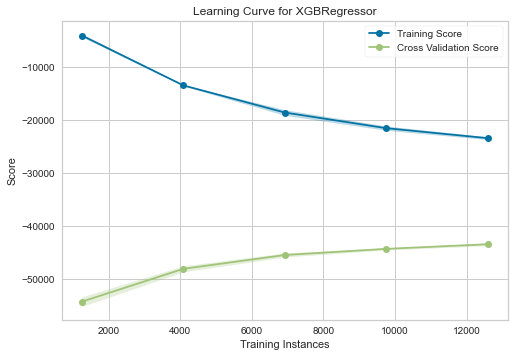

<AxesSubplot:title={'center':'Learning Curve for XGBRegressor'}, xlabel='Training Instances', ylabel='Score'>

In [45]:
lcurve = LearningCurve(xgb, cv=5, scoring='neg_root_mean_squared_error')
lcurve.fit(X_train_prepared, y_train)
lcurve.poof()

The training and cross validation score did not converge yet, so probably this model would benefit with more data 

## 8.2 RFE CV

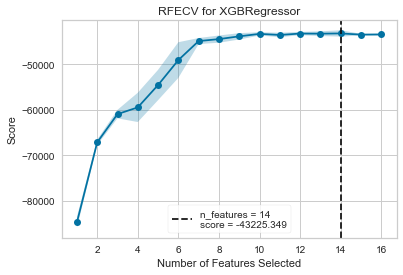

<AxesSubplot:title={'center':'RFECV for XGBRegressor'}, xlabel='Number of Features Selected', ylabel='Score'>

In [156]:
rfe = RFECV(xgb,cv=5, scoring='neg_root_mean_squared_error' )
rfe.fit(X_train_prepared, y_train)
rfe.poof()

In [157]:
cat_encoder = full_pipeline.named_transformers_['cat']
cat_one_hot_feat = list(cat_encoder.categories_[0])
features = num_features + cat_one_hot_feat
list(zip(features,rfe.support_,rfe.ranking_))

[('longitude', True, 1),
 ('latitude', True, 1),
 ('housing_median_age', True, 1),
 ('total_rooms', True, 1),
 ('total_bedrooms', True, 1),
 ('population', False, 2),
 ('households', True, 1),
 ('median_income', True, 1),
 ('rooms_per_household', True, 1),
 ('bedrooms_per_room', True, 1),
 ('population_per_household', True, 1),
 ('1H_OCEAN', True, 1),
 ('INLAND', True, 1),
 ('ISLAND', False, 3),
 ('NEAR_BAY', True, 1),
 ('NEAR_OCEAN', True, 1)]

although the RFECV package has pointing 12 features as ideal, i optate to not exclude any feature because all the ones that was suggest to exclude or are use to derivate other features that are important or is associate to ocean proximity variables as 'Island'. Beyond that, the RMSE only increase 150 points, the main benefit would be make a easier deploy e more simple model, maybe later i'll try that. Lets see the final performance with the test set.

# 9. Hyperparameter fine-tuning

In [41]:
# new pipeline with drop of features

final_X_train_num = X_train.drop(['ocean_proximity','population'], axis=1)

final_num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')),
                             ('normal', PowerTransformer(method='yeo-johnson')),
                             ('standard_scaler', StandardScaler())
])

final_num_features = list(final_X_train_num)
final_cat_features = ['ocean_proximity']

final_full_pipeline = ColumnTransformer([('num', final_num_pipeline, final_num_features),
                                      ('cat', OneHotEncoder(), final_cat_features)
], verbose_feature_names_out=False)

final_X_train_prepared = pd.DataFrame(final_full_pipeline.fit_transform(X_train), 
                                columns=final_full_pipeline.get_feature_names_out())
final_X_train_prepared

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,households,median_income,rooms_per_household,bedrooms_per_room,population_per_household,ocean_proximity_1H_OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR_BAY,ocean_proximity_NEAR_OCEAN
0,-1.318451,1.055896,1.782406,-0.523576,-0.437691,-0.437965,0.025772,-0.258692,0.396081,-0.975415,0.0,0.0,0.0,1.0,0.0
1,-1.338145,1.812213,-1.066788,0.218680,-0.005212,0.148842,-0.041468,0.233388,-0.677733,0.179627,0.0,1.0,0.0,0.0,0.0
2,0.631246,-0.733317,1.429462,-0.710869,-0.466750,-0.369255,-1.709146,-1.056291,0.914324,2.027010,1.0,0.0,0.0,0.0,0.0
3,0.818338,-0.842841,0.775113,-0.665098,-0.738572,-0.579233,-0.100515,-0.278143,-0.124432,-0.633104,1.0,0.0,0.0,0.0,0.0
4,-0.747327,0.966189,-0.067162,-1.093963,-1.236269,-1.205841,-0.599935,0.303364,-0.354404,-0.206905,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15735,-1.328298,1.205939,-0.226750,-0.331660,-0.077738,-0.081504,-0.286383,-0.696391,0.859612,-0.386760,0.0,0.0,0.0,1.0,0.0
15736,0.700175,-0.733317,0.922874,0.152961,0.502189,0.533680,-1.105125,-0.936104,1.008546,0.870700,1.0,0.0,0.0,0.0,0.0
15737,0.493389,-0.596298,-0.146667,0.515672,0.358153,0.496450,0.659045,0.129871,-0.464594,-0.145115,1.0,0.0,0.0,0.0,0.0
15738,0.818338,-0.842841,-0.226750,-0.977135,-0.793590,-0.676897,-0.223859,-1.000805,0.791939,1.111931,1.0,0.0,0.0,0.0,0.0


Let's discuss about the hyperparameters that we will tune. 

First of all the xgboost has a lot of hyperparameters, i choose some of them that can adjust regularization better, to avoid overfitting and achive a good generalization. 

Eta: Step size shrinkage used in update to prevents overfitting. After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative.

Subsample: Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. and this will prevent overfitting. Subsampling will occur once in every boosting iteration.

Max_depth: Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit. 0 indicates no limit on depth. Beware that XGBoost aggressively consumes memory when training a deep tree. exact tree method requires non-zero value.

N_estimators: Number of gradient boosted trees. Equivalent to number of boosting rounds.

Random_state: state of randomness.

Source: https://xgboost.readthedocs.io/en/stable/parameter.html ; https://xgboost.readthedocs.io/en/stable/python/python_api.html ;
 Book: "Machine learning: Guia de referência rápida" 

In [42]:
#hyperparameter fine-tuning with grid search
param_grid = [{'eta': [0.01, 0.03, 0.05], 'subsample': [0.3, 0.5, 0.7], 'max_depth':[5, 10],
               'n_estimators': [1000, 1500, 2000], 'random_state': [42]}]

grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='neg_root_mean_squared_error', return_train_score=True)

grid_search.fit(final_X_train_prepared, y_train)

print(grid_search.best_params_)

print(f'RMSE: {-grid_search.best_score_}')

grid_search.best_estimator_

{'eta': 0.05, 'max_depth': 5, 'n_estimators': 2000, 'random_state': 42, 'subsample': 0.7}
RMSE: 41495.87596092814


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.05,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.0500000007, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=2000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, ...)

# 10. Final model

In [46]:
#Evaluate with the test set
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop(['median_house_value'], axis=1)
y_test = strat_test_set['median_house_value'].copy()

X_test['rooms_per_household'] = X_test['total_rooms']/X_test['households']
X_test['bedrooms_per_room'] = X_test['total_bedrooms']/X_test['total_rooms']
X_test['population_per_household'] = X_test['population']/X_test['households']

X_test = X_test.drop(['population'], axis=1)

X_test_prepared = final_full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)

final_rmse = np.sqrt(final_mse)

final_mae = mean_absolute_error(y_test, final_predictions)

final_r2 = r2_score(y_test, final_predictions)

dicionario = {'RMSE': final_rmse, 'MAE': final_mae, 'R²': final_r2}
resultado = pd.DataFrame(dicionario, index=[0])
resultado

,RMSE,MAE,R²
0,39745.535561,26640.835081,0.829436


We reached a RMSE of 39.745 and the book had reached a RMSE of 47.730, so the model has been solidly improved.

C:\Users\Dell\Anaconda3\Anaconda\envs\Project Housing 2\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



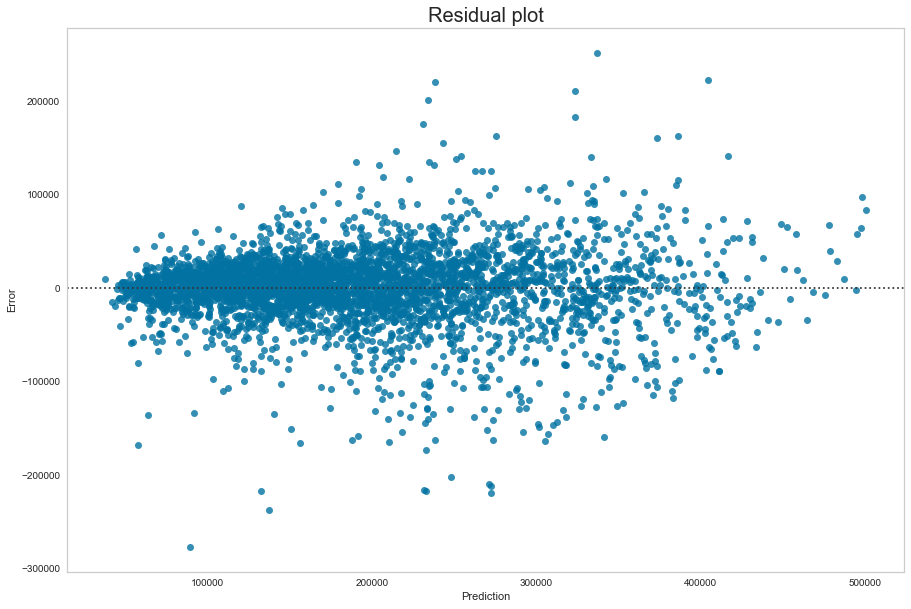

In [47]:
aux = pd.DataFrame( { 'y_test': y_test, 'Prediction': final_predictions,'Error': final_predictions - y_test} )
plt.figure(figsize=(15,10));
sns.residplot(aux['Prediction'], aux['Error']);
plt.title("Residual plot", fontsize=20);
plt.grid();

# 11. Deploy

In [50]:
import joblib

In [51]:
data_train = X_train
data_train['median_house_value'] = y_train
data_train.to_csv('data_train.csv')

In [52]:
final_data_train = final_X_train_prepared
final_data_train['median_house_value'] = y_train
final_data_train.to_csv('final_data_train.csv')

In [53]:
joblib.dump(final_model, 'housing.joblib')

['housing.joblib']

In [54]:
joblib.dump(final_full_pipeline, 'pipe.joblib')

['pipe.joblib']